In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import seaborn as sns
from textwrap import fill
from synergy_dataset import Dataset, iter_datasets

## Get the latest data from the HPC

In [2]:
# %%sh
# bash sync.sh

## Database of SVM runs

In [3]:
con = sqlite3.connect('output_data/experiments.sql')
df = pd.read_sql_query('SELECT * FROM runs',con)
df

,run_id,exp_started,version,thread
0,1,2024-02-07 17:10:14,0.1.0,83
1,2,2024-02-07 17:10:14,0.1.0,14
2,3,2024-02-07 17:10:14,0.1.0,72
3,4,2024-02-07 17:10:14,0.1.0,47
4,5,2024-02-07 17:10:14,0.1.0,19
...,...,...,...,...
95,96,2024-02-07 17:10:22,0.1.0,26
96,97,2024-02-07 17:10:22,0.1.0,38
97,98,2024-02-07 17:10:22,0.1.0,36
98,99,2024-02-07 17:10:22,0.1.0,41


In [4]:
version = '0.1.0'
stmt = f'SELECT screened_order,review,relevant,thread FROM ordered_records orr LEFT JOIN runs ON orr.run_id=runs.run_id WHERE version="{version}"'
#stmt = 'SELECT * FROM ordered_records WHERE run_id=1'
df = pd.read_sql_query(stmt,con)
df.groupby('review')['thread'].nunique()

review
Appenzeller-Herzog_2019    100
Bos_2018                   100
Brouwer_2019                99
Chou_2003                   99
Chou_2004                   99
Donners_2021                99
Hall_2012                   97
Jeyaraman_2020              97
Leenaars_2019               97
Leenaars_2020               91
Meijboom_2021               91
Menon_2022                  91
Moran_2021                  87
Muthu_2021                  87
Nelson_2002                 87
Oud_2018                    87
Radjenovic_2013             64
Sep_2021                    64
Smid_2020                   52
van_de_Schoot_2018          10
van_der_Valk_2021            8
van_der_Waal_2022            3
Name: thread, dtype: int64

In [5]:
d_map = {}
max_len = 10
for d in iter_datasets():
    ti = d.metadata['publication']['title']
    d_map[d.name] = fill(ti, width=80)
d_map

{'Appenzeller-Herzog_2019': 'Comparative effectiveness of common therapies for Wilson disease: A systematic\nreview and meta‐analysis of controlled studies',
 'Bos_2018': 'Cerebral small vessel disease and the risk of dementia: A systematic review and\nmeta‐analysis of population‐based evidence',
 'Brouwer_2019': 'Psychological theories of depressive relapse and recurrence: A systematic review\nand meta-analysis of prospective studies',
 'Chou_2003': 'Comparative efficacy and safety of long-acting oral opioids for chronic non-\ncancer pain: a systematic review',
 'Chou_2004': 'Comparative efficacy and safety of skeletal muscle relaxants for spasticity and\nmusculoskeletal conditions: a systematic review',
 'Donners_2021': 'Pharmacokinetics and Associated Efficacy of Emicizumab in Humans: A Systematic\nReview',
 'Hall_2012': 'A Systematic Literature Review on Fault Prediction Performance in Software\nEngineering',
 'Jeyaraman_2020': 'Does the Source of Mesenchymal Stem Cell Have an Effe

In [6]:
def order_score(x):
    return 1-(x-x.min())/(x.max()-x.min())

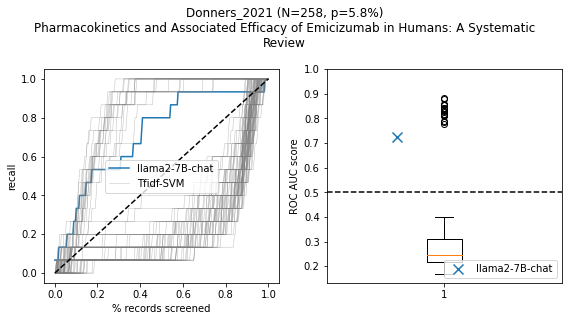

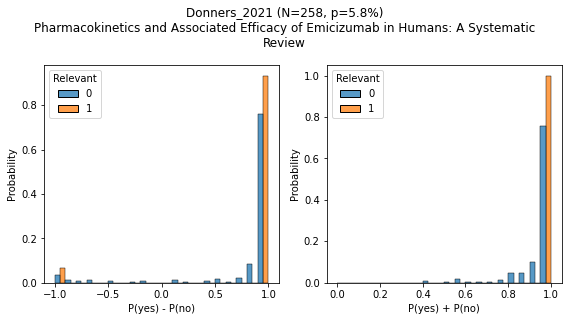

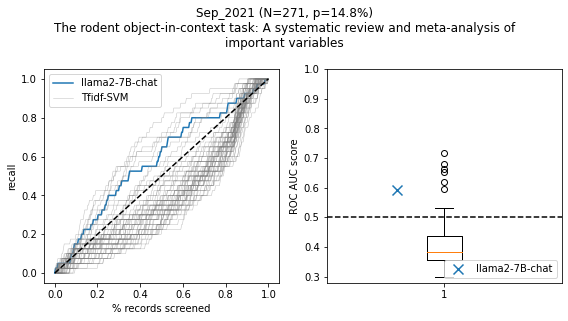

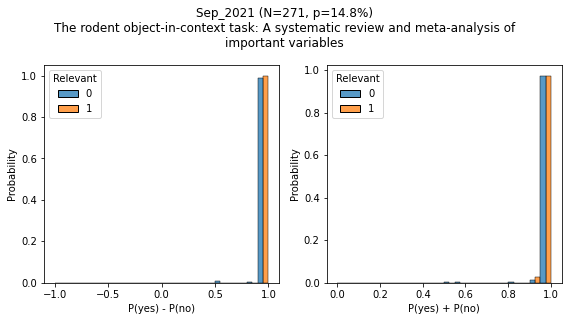

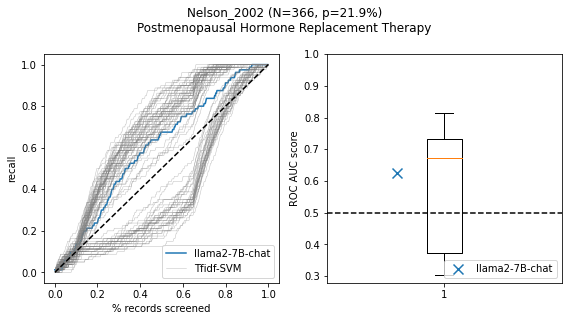

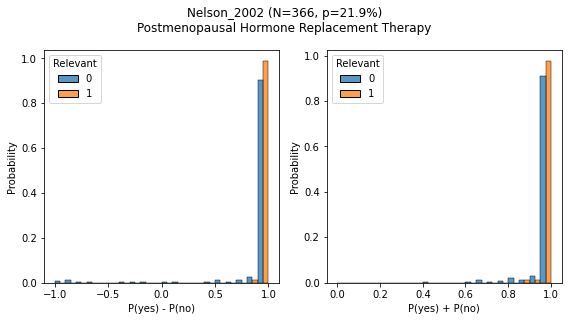

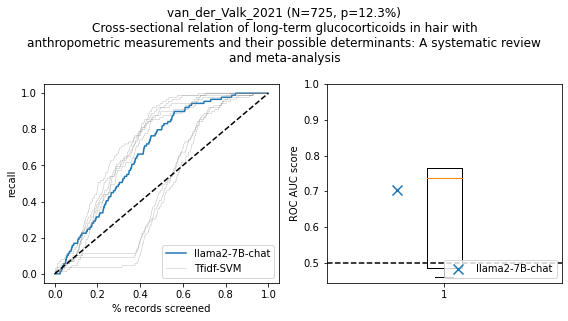

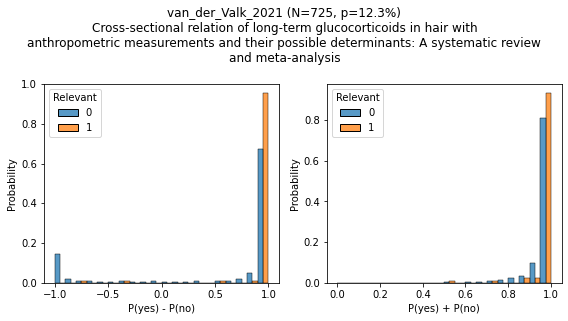

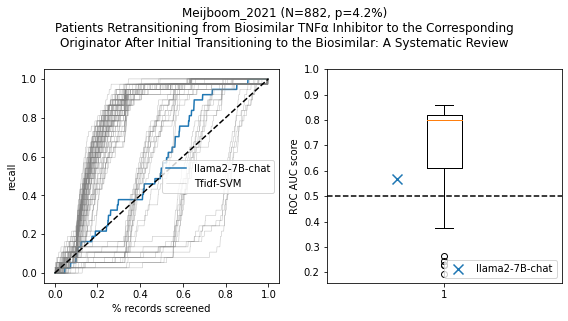

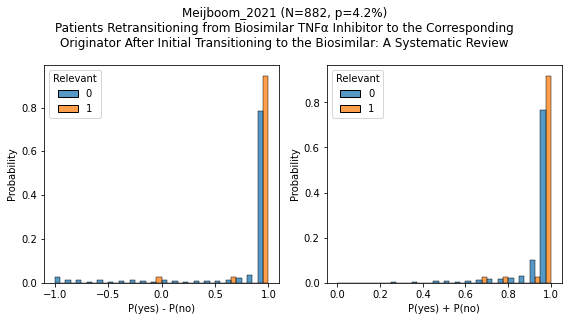

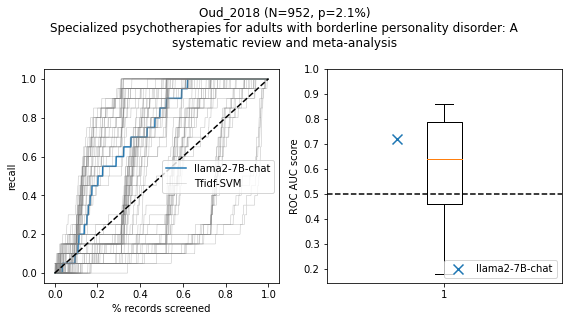

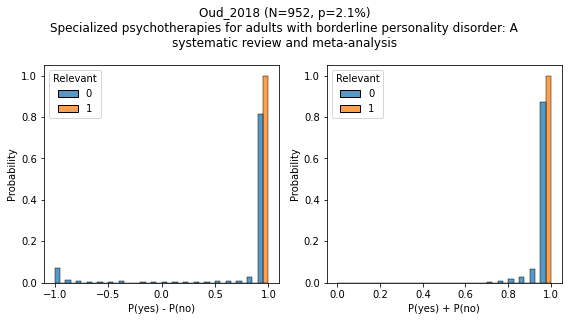

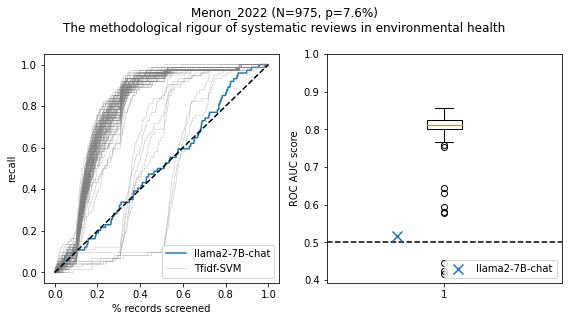

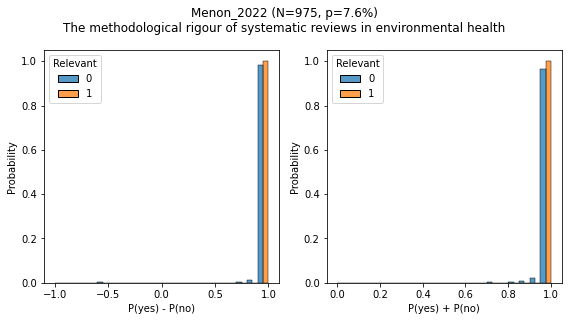

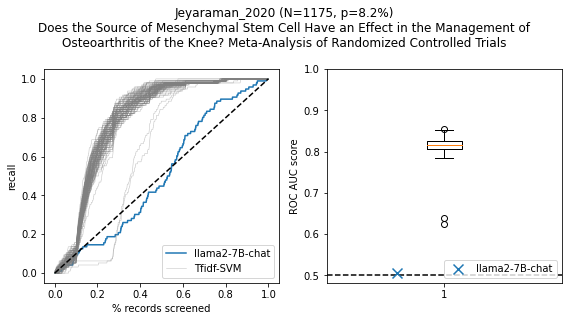

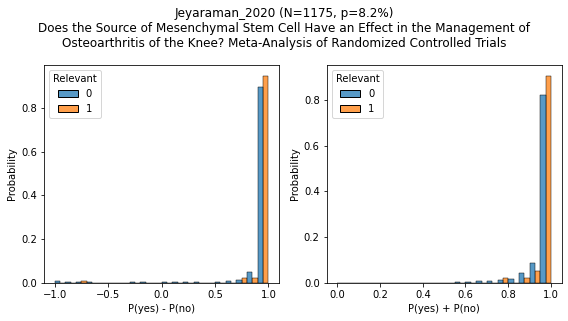

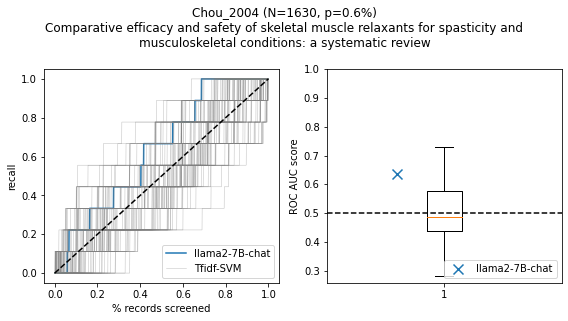

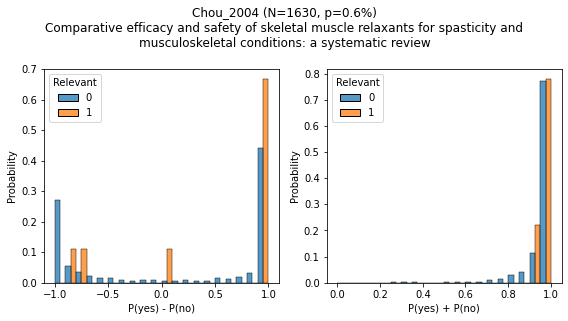

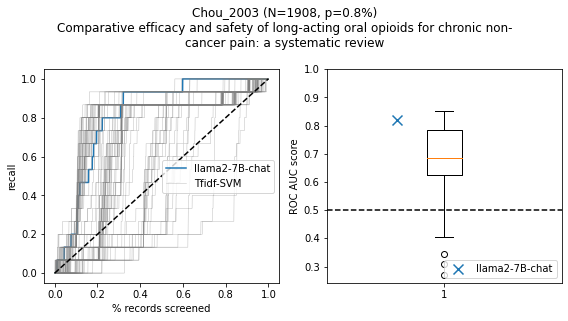

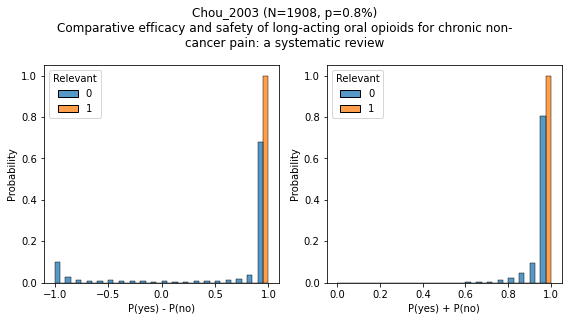

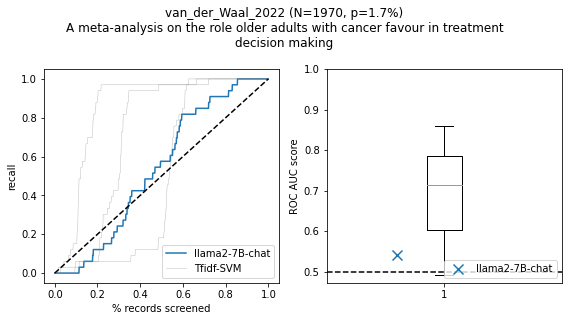

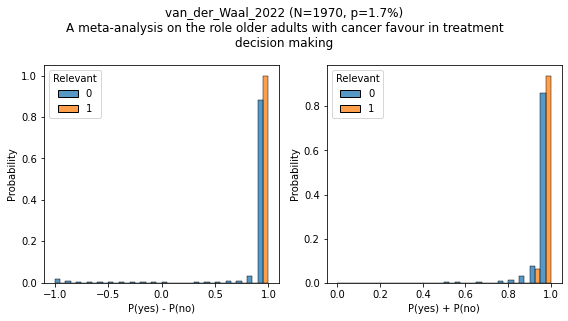

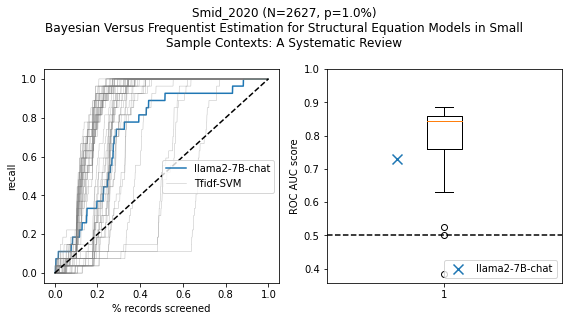

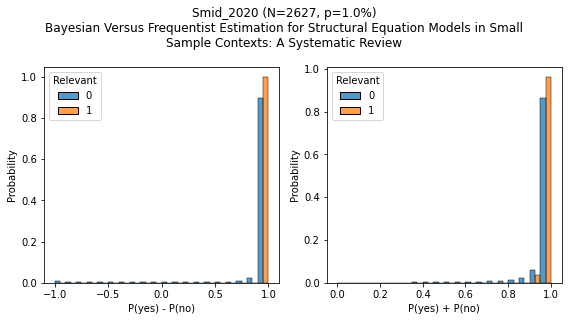

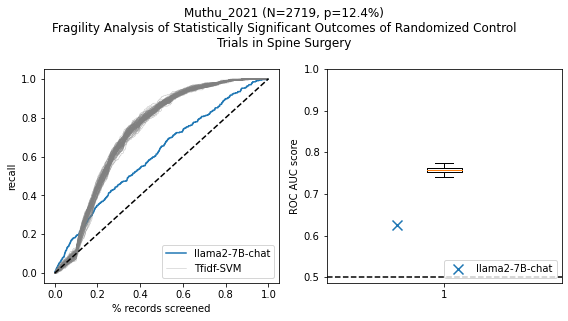

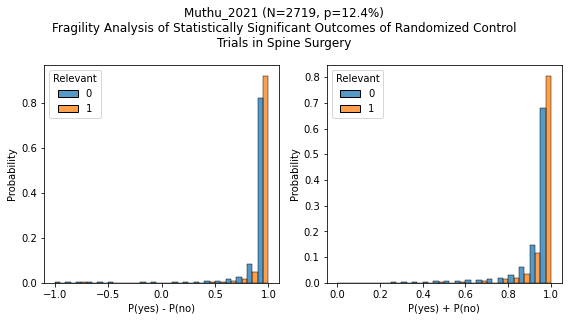

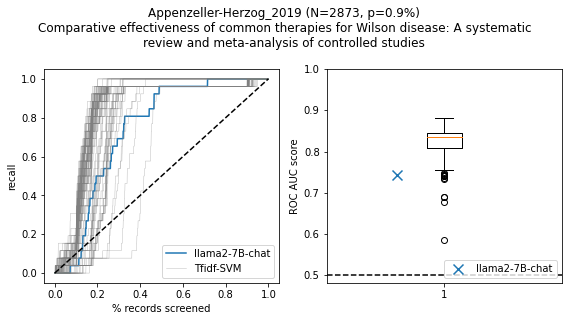

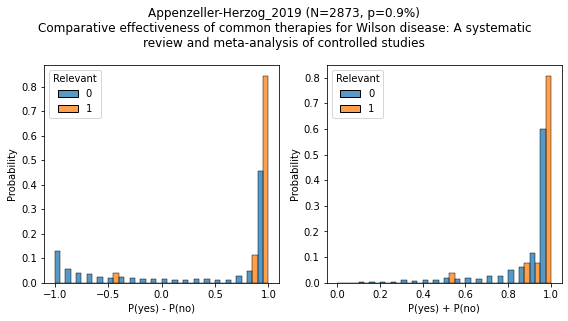

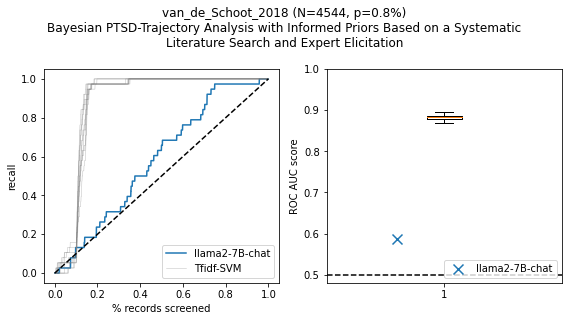

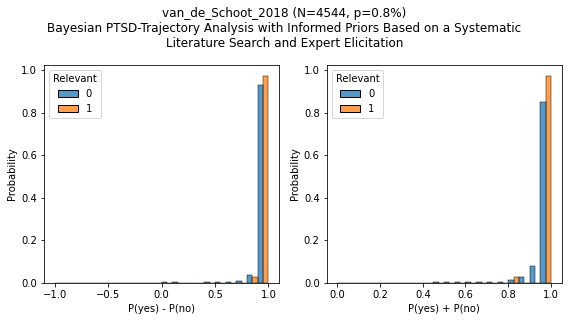

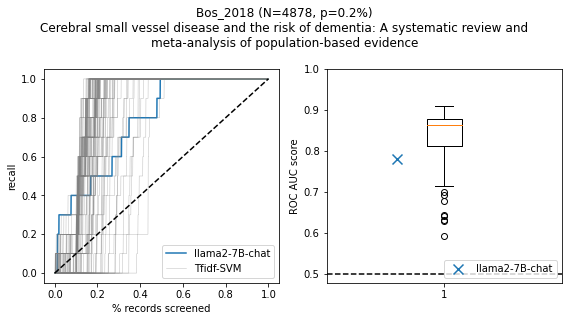

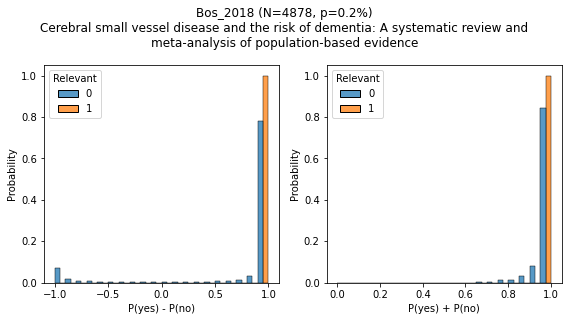

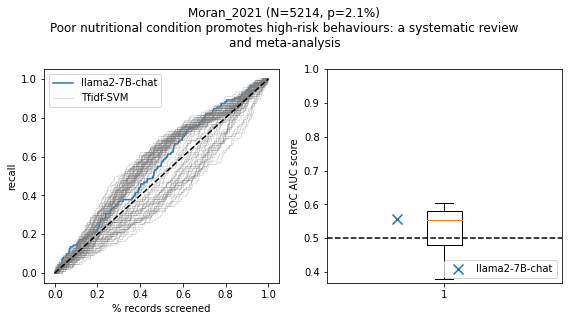

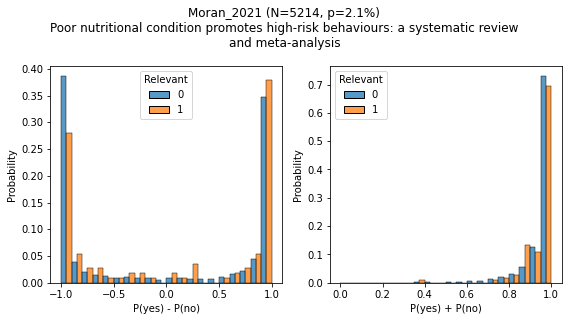

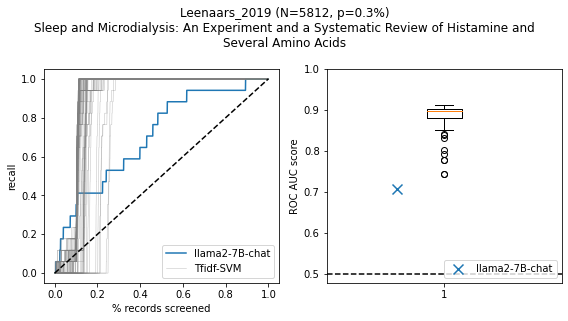

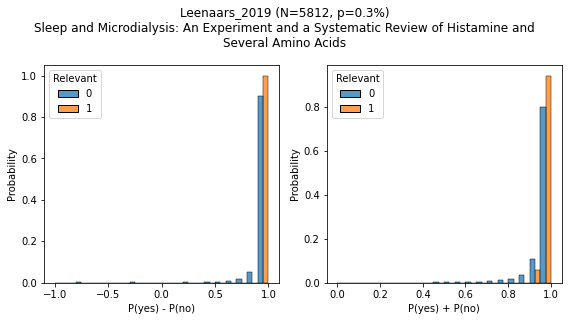

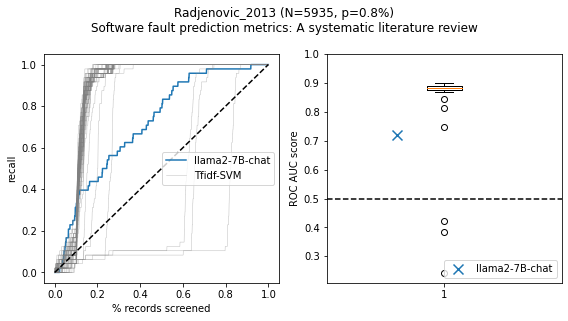

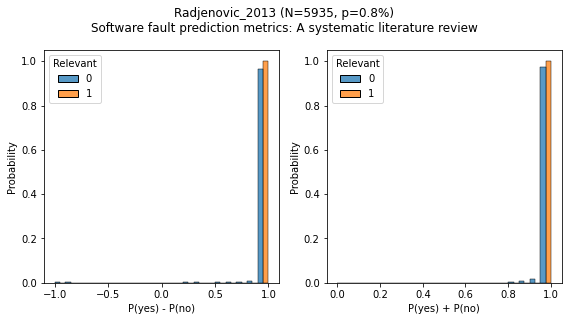

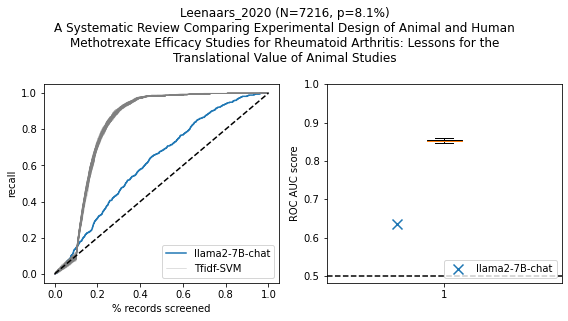

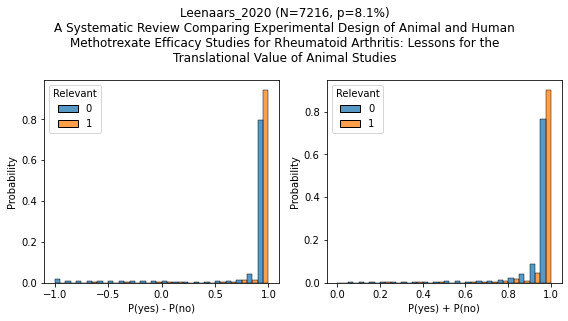

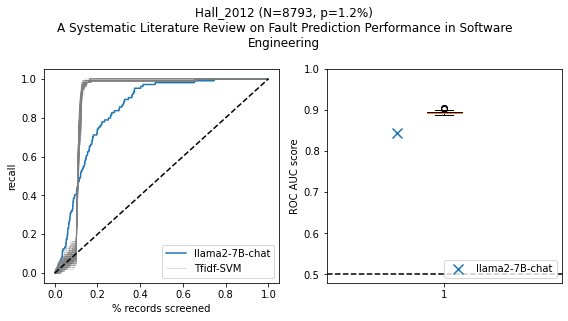

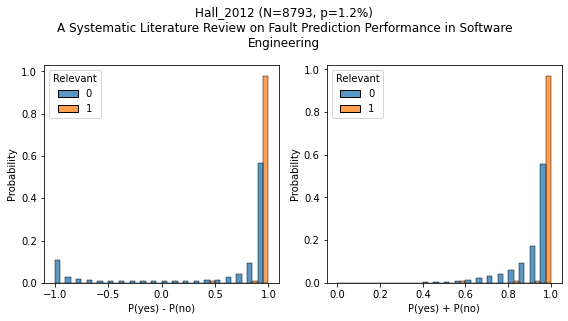

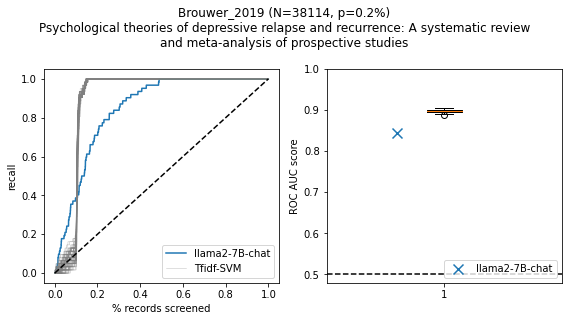

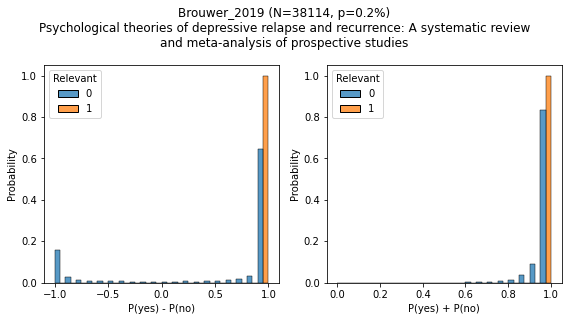

In [7]:
svm_auc_scores = []
llm_auc_scores = []
reviews = []

for i, row in df.groupby('review')['screened_order'].max().sort_values().reset_index().iterrows():
    review  = row['review']
    rdf = df[df['review']==review]
    try:
        llm_df = pd.read_csv(f'output_data/{review}_LLM.csv').dropna()
    except:
        continue
    if llm_df.shape[0] < 5:
        continue
    # Sort LLM results in descending order of pred, the order we would screen them
    llm_df = llm_df.sort_values('pred', ascending=False)
    # Calculate recall, the order, and x, the proportion of documents screened
    llm_df['recall'] = llm_df['y'].cumsum() / llm_df['y'].sum()
    llm_df['order'] = np.arange(llm_df.shape[0])
    llm_df['x'] = llm_df['order'] / llm_df.shape[0] 
    
    # Setup graph with two panels
    fig, axs = plt.subplots(1,2, figsize=(8,4.5))
    ax = axs[0]
    
    # Plot LLM recall curve
    ax.plot(llm_df['x'], llm_df['recall'], label='llama2-7B-chat')
    
    study_title = f'{review} (N={llm_df.shape[0]}, p={llm_df["y"].sum()/llm_df.shape[0]:.1%})'
    reviews.append(study_title)
    plt.suptitle(study_title + '\n' + d_map[review])
    
    #  Go through each active learning run, and plot progress
    aucs = []
    for i, (name, group) in enumerate(rdf.groupby('thread')):
        group = group.sort_values('screened_order').reset_index()
        group['score'] = order_score(group['screened_order'])
        group['x'] = group['screened_order'] / group.shape[0]
        group['recall'] = group['relevant'].cumsum()/group['relevant'].sum()
        aucs.append(roc_auc_score(group['relevant'],group['score']))
        ax.plot(group['x'], group['recall'], color='grey',alpha=0.5,lw=0.5, label='Tfidf-SVM' if i==0 else None)
    svm_auc_scores.append(aucs)
    
    # Plot a diagonal line showing random chance
    ax.plot([0,1],[0,1], color='black',ls='--')
    
    ax.legend()
    
    # Show the distribution of ROC AUC scores
    axs[1].boxplot(aucs)
    axs[1].axhline(0.5, color='black', ls='--')
    
    # Calculate LLM ROC AUC score and plot it with an x
    auc = roc_auc_score(llm_df['y'], llm_df['pred'])
    llm_auc_scores.append(auc)
    axs[1].scatter(
        0.8, auc,     
        marker='x',
        s=100,
        zorder=50,
        label='llama2-7B-chat'
    )
    
    # Legend and axis labels
    axs[1].legend(loc='lower right')
    axs[0].set_xlabel('% records screened')
    axs[0].set_ylabel('recall')
    axs[1].set_ylim(ymax=1)
    axs[1].set_ylabel('ROC AUC score')
    plt.tight_layout()
    plt.savefig(f'figures/{review}.pdf', bbox_inches='tight')
    plt.show()
    
    # New plot for distribution of p scores
    fig, axs = plt.subplots(1,2, figsize=(8,4.5))

    # Distribution of p(Yes)-P(no)
    g = sns.histplot(
        llm_df, hue='y', x='pred', stat='probability', 
        multiple='dodge', common_norm=False, ax=axs[0],
        binwidth=0.1, binrange=[-1,1], legend=True,
    )
    leg = g.axes.get_legend()
    leg.set_title('Relevant')
    axs[0].set_xlabel('P(yes) - P(no)')
    
    # Distribution of p(Yes)+P(no)
    g = sns.histplot(
        llm_df, hue='y', x='pmass', stat='probability', 
        multiple='dodge', common_norm=False, ax=axs[1],
        binwidth=0.05, binrange=[0,1], legend=True,
    )
    leg = g.axes.get_legend()
    leg.set_title('Relevant')
    axs[1].set_xlabel('P(yes) + P(no)')
    plt.suptitle(study_title + '\n' + d_map[review])
    
    fig.tight_layout()
    plt.savefig(f'figures/{review}_p_distribution.pdf', bbox_inches='tight')
    plt.show()


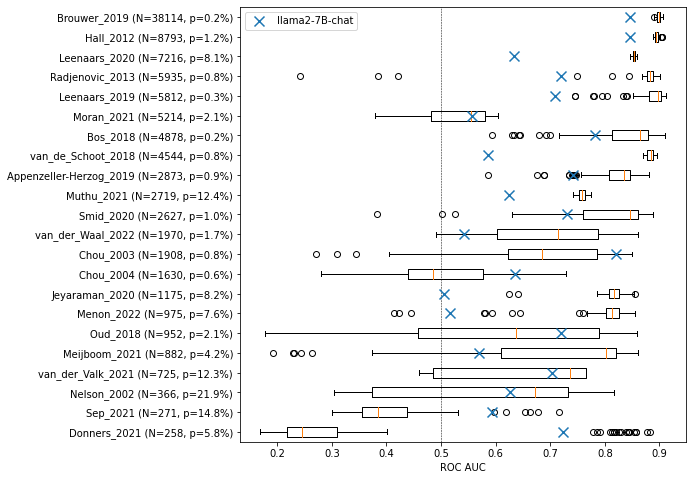

In [8]:
fig, ax = plt.subplots(figsize=(8,8))

ax.boxplot(svm_auc_scores, vert=False)
#llm_auc_scores
ax.set_yticklabels(reviews)
ax.scatter(
    llm_auc_scores, 
    np.arange(len(llm_auc_scores))+1,
    marker='x',
    s=100,
    zorder=50,
    label='llama2-7B-chat'
)
#sns.stripplot(svm_auc_scores, orient='h')
ax.legend()
ax.axvline(0.5, lw=0.5, ls='--', color='black')
ax.set_xlabel('ROC AUC')
plt.savefig('figures/llm_svm_roc.pdf', bbox_inches='tight')
plt.show()